# Classification Fundamentals and Problem Formulation

## Supervised Classification

Supervised Classification is a machine learning task where algorithms learn to predict discrete class labels for new data based on labeled training examples.

## Key Components

1. **Training Data**: Labeled examples (X, y) where X = features, y = class labels
2. **Features**: Input variables that describe each sample
3. **Labels**: Target classes we want to predict
4. **Model**: Algorithm that learns the mapping from features to labels
5. **Evaluation**: Metrics to measure how well our model performs

## Classification Problem: 3W Oil Well Fault Detection

- **Objective**: Classify oil well operational states from sensor data
- **Input Features**: Time series sensor measurements (flattened into feature vectors)
- **Output Classes**: Different types of operational faults (0=normal, 1-9=different fault types)
- **Challenge**: Multi-class classification with imbalanced classes

## Problem Characteristics
- **Multi-class**: 10 different classes (0-9)
- **Time Series**: Sequential sensor measurements
- **High Dimensional**: Many sensors × time steps = many features
- **Imbalanced**: Some fault types are much rarer than others
- **Real-world**: Noisy, complex industrial data

In [1]:
# ============================================================
# LOAD 3W DATASET FOR SUPERVISED CLASSIFICATION
# ============================================================

print("Loading 3W Dataset for Supervised Classification")
print("=" * 55)

# Import required modules
import sys
import os
import time
import pandas as pd
import numpy as np

# Add src directory to path
sys.path.append("src")

# Import data loading utilities
from src.data_persistence import DataPersistence
from src import config

start_time = time.time()

try:
    print("Initializing data persistence...")
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    print(f"Using format: {config.SAVE_FORMAT}")

    # Check windowed data directory
    windowed_dir = os.path.join(persistence.cv_splits_dir, "windowed")
    
    if not os.path.exists(windowed_dir):
        raise FileNotFoundError("No windowed data directory found. Please run Data Treatment notebook first.")
    
    # Find fold directories
    fold_dirs = [
        d for d in os.listdir(windowed_dir)
        if d.startswith("fold_") and os.path.isdir(os.path.join(windowed_dir, d))
    ]
    fold_dirs.sort()
    
    if not fold_dirs:
        raise FileNotFoundError("No fold directories found in windowed data.")
    
    print(f"Found {len(fold_dirs)} folds, loading data...")
    
    # Load data from all folds
    all_train_windows = []
    all_train_classes = []
    all_train_fold_info = []
    all_test_windows = []
    all_test_classes = []
    all_test_fold_info = []

    load_start = time.time()

    for fold_name in fold_dirs:
        fold_path = os.path.join(windowed_dir, fold_name)
        
        # Load training data
        train_pickle = os.path.join(fold_path, f"train_windowed.{config.SAVE_FORMAT}")
        train_parquet = os.path.join(fold_path, "train_windowed.parquet")

        if os.path.exists(train_pickle):
            fold_train_dfs, fold_train_classes = persistence._load_dataframes(
                train_pickle, config.SAVE_FORMAT
            )
        elif os.path.exists(train_parquet):
            fold_train_dfs, fold_train_classes = persistence._load_from_parquet(train_parquet)
        else:
            continue
            
        all_train_windows.extend(fold_train_dfs)
        all_train_classes.extend(fold_train_classes)
        all_train_fold_info.extend([fold_name] * len(fold_train_dfs))

        # Load test data
        test_pickle = os.path.join(fold_path, f"test_windowed.{config.SAVE_FORMAT}")
        test_parquet = os.path.join(fold_path, "test_windowed.parquet")

        if os.path.exists(test_pickle):
            fold_test_dfs, fold_test_classes = persistence._load_dataframes(
                test_pickle, config.SAVE_FORMAT
            )
        elif os.path.exists(test_parquet):
            fold_test_dfs, fold_test_classes = persistence._load_from_parquet(test_parquet)
        else:
            continue
            
        all_test_windows.extend(fold_test_dfs)
        all_test_classes.extend(fold_test_classes)
        all_test_fold_info.extend([fold_name] * len(fold_test_dfs))

    load_time = time.time() - load_start

    if not all_train_windows or not all_test_windows:
        raise ValueError("No data loaded from any fold")

    # Store loaded data
    train_dfs = all_train_windows
    train_classes = all_train_classes
    train_fold_info = all_train_fold_info
    test_dfs = all_test_windows
    test_classes = all_test_classes
    test_fold_info = all_test_fold_info

    # Display dataset summary
    first_train_window = train_dfs[0]
    train_unique, train_counts = np.unique(train_classes, return_counts=True)
    test_unique, test_counts = np.unique(test_classes, return_counts=True)

    print(f"\nDataset Summary:")
    print(f"   Training windows: {len(train_dfs)}")
    print(f"   Test windows: {len(test_dfs)}")
    print(f"   Window shape: {first_train_window.shape}")
    print(f"   Classes: {sorted(train_unique)}")
    print(f"   Folds processed: {len(fold_dirs)}")
    
    total_time = time.time() - start_time
    print(f"   Loading time: {load_time:.2f}s (total: {total_time:.2f}s)")

except Exception as e:
    print(f"Error loading data: {str(e)}")
    print("Troubleshooting:")
    print("   1. Ensure 'Data Treatment.ipynb' completed successfully")
    print("   2. Check if windowed data exists in processed_data directory")
    
    # Initialize empty variables for error case
    train_dfs = []
    train_classes = []
    train_fold_info = []
    test_dfs = []
    test_classes = []
    test_fold_info = []

Loading 3W Dataset for Supervised Classification
Initializing data persistence...
Using format: pickle
Found 3 folds, loading data...
Initializing data persistence...
Using format: pickle
Found 3 folds, loading data...

Dataset Summary:
   Training windows: 505336
   Test windows: 78491
   Window shape: (300, 4)
   Classes: [np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9')]
   Folds processed: 3
   Loading time: 50.42s (total: 50.47s)

Dataset Summary:
   Training windows: 505336
   Test windows: 78491
   Window shape: (300, 4)
   Classes: [np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9')]
   Folds processed: 3
   Loading time: 50.42s (total: 50.47s)


# Enhanced Analysis Summary

## Five Key Analysis Features

The enhanced classification provides five critical analysis capabilities:

### 1. Configurable Class Selection
- **Purpose**: Choose which specific classes to include in your analysis
- **Configuration**: Controlled via `src/config.py` for easy management
- **Options**: 
  - Default: Exclude only class 0 (analyze all fault types 1-9)
  - Custom: Select specific classes of interest (e.g., [2,3,8] for particular faults)
  - Presets: Use pre-configured selections for common scenarios
- **Use Case**: Focus on specific fault types, reduce problem complexity, targeted analysis

### 2. Accuracy Per Fold
- **Purpose**: Understand model consistency across different data splits
- **Insight**: Identifies if models perform consistently or if some folds are particularly challenging
- **Use Case**: Helps detect dataset bias, temporal patterns, or fold-specific issues

### 3. Accuracy Per Class
- **Purpose**: Understand model performance on each selected class
- **Insight**: Reveals which fault types are easier/harder to detect
- **Use Case**: Critical for industrial applications where missing certain fault types has higher cost

### 4. Flexible Class Filtering
- **Purpose**: Either exclude normal operation (class 0) or focus on specific fault types
- **Insight**: Create focused classification problems aligned with operational needs
- **Use Case**: 
  - Fault diagnosis systems (exclude normal operation)
  - Specific fault type analysis (select particular faults)
  - Simplified problems for testing and development

### 5. Configurable Test Data Balancing
- **Purpose**: Ensure robust evaluation with sufficient samples per class
- **Configuration**: Enable/disable via config file settings
- **Insight**: Balances test data to have minimum samples per selected class for reliable metrics
- **Use Case**: Prevents evaluation bias due to class imbalance in test set

## Configuration Management

### Config File Location:
```
src/config.py
└── CLASSIFICATION_CONFIG section
└── CLASSIFICATION_PRESETS section
```

### Available Presets:
```python
CLASSIFICATION_PRESETS = {
    'all_faults': None,                # All fault types (exclude class 0)
    'specific_faults': [2, 3, 8],     # User-defined specific faults
    'early_faults': [1, 2, 3, 4, 5],  # First 5 fault types
    'late_faults': [7, 8, 9],         # Last 3 fault types
    'odd_faults': [1, 3, 5, 7, 9],    # Odd-numbered fault types
    'even_faults': [2, 4, 6, 8],      # Even-numbered fault types
    'critical_faults': [3, 6, 8, 9],  # Critical operational faults
    'minor_faults': [1, 2, 4, 5, 7],  # Minor operational faults
    'binary_test': [3, 8],            # Simple binary classification
}
```

### Configuration Examples:

#### In config.py:
```python
CLASSIFICATION_CONFIG = {
    'selected_classes': [2, 3, 8],     # Default selection
    'balance_test': False,             # Test balancing setting
    'min_test_samples_per_class': 300, # Min samples when balancing
    'balance_classes': True,           # Training balancing
    'balance_strategy': 'combined',    # Balancing strategy
    'max_samples_per_class': 1000,     # Training limit
    'verbose': True                    # Progress display
}
```

#### In notebook override:
```python
# Quick override in notebook
selected_classes = config.CLASSIFICATION_PRESETS['binary_test']  # Use preset
# OR
selected_classes = [1, 4, 7]  # Custom selection
```

Running Supervised Classification Analysis
Training windows: 505336
Test windows: 78491
Fold information: 3 folds detected

Classification Configuration:
   Selected classes: ['3', '4', '8']
   Test balancing: False
   All selected classes found in data

Training 7 models...


Training Models:   0%|          | 0/7 [00:00<?, ?model/s]

⚖️ Class Balancing Strategy: combined
   • Original class distribution: {np.int16(3): 30861, np.int16(4): 6820, np.int16(0): 2915, 8: 21987}
📉 Random Undersampling (strategy: auto)
   • Original class distribution: {np.int16(3): 30861, np.int16(4): 6820, np.int16(0): 2915, 8: 21987}
   • Target class counts: {np.int16(3): 14403, np.int16(4): 14403, np.int16(0): 14403, 8: 14403}
   • Final class distribution: {np.int16(3): 14403, np.int16(4): 6820, np.int16(0): 2915, 8: 14403}
   • Samples: 62583 → 38541
📈 Random Oversampling (strategy: auto)
   • Original class distribution: {np.int16(3): 14403, np.int16(4): 6820, np.int16(0): 2915, 8: 14403}
   • Target class counts: {np.int16(3): 14403, np.int16(4): 14403, np.int16(0): 14403, 8: 14403}
   • Final class distribution: {np.int16(3): 14403, np.int16(4): 14403, np.int16(0): 14403, 8: 14403}
   • Samples: 38541 → 57612
   • Target class counts: {np.int16(3): 14403, np.int16(4): 14403, np.int16(0): 14403, 8: 14403}
   • Final class distribu

Training Models: 100%|██████████| 7/7 [01:34<00:00, 13.54s/model]

Complete Model Performance Comparison:
Model                     Train Acc    Test Acc     Train Time   Overfitting 
--------------------------------------------------------------------------------
Decision Tree             0.944        0.836        1.740        0.107       
Random Forest             0.974        0.863        0.571        0.112       
Linear SVM                0.790        0.756        0.172        0.034       
RBF SVM                   0.828        0.756        0.064        0.072       
Simple Neural Network     0.879        0.752        2.580        0.128       
Deep Neural Network       0.912        0.788        7.793        0.124       
Regularized Neural Network 0.900        0.810        5.626        0.090       

Model Rankings:
   Best Test Accuracy: Random Forest (0.863)
   ⚡ Fastest Training: RBF SVM (0.064s)
   Least Overfitting: Linear SVM (gap: 0.034)

📋 Detailed Classification Report (Random Forest):
              precision    recall  f1-score   support

 


c:\Users\lucas\Documents\GitHub\3W\resources\introduction_to_ml_applied_to_mts\src\supervised_classification.py:788: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(
c:\Users\lucas\Documents\GitHub\3W\resources\introduction_to_ml_applied_to_mts\src\supervised_classification.py:816: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(


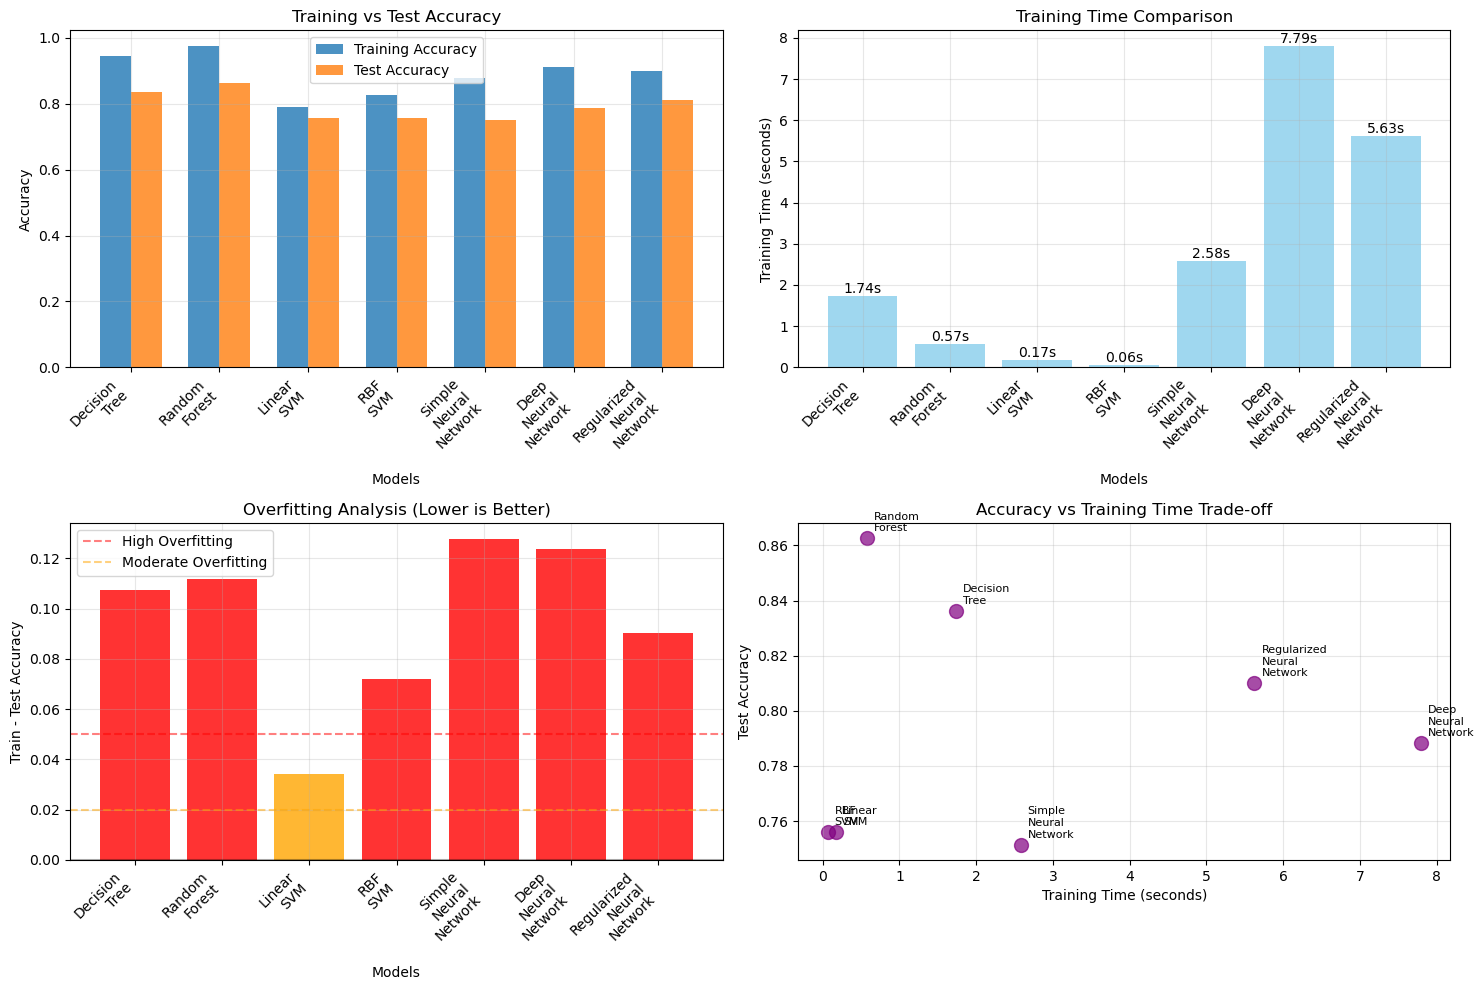


Classification analysis completed successfully!


In [2]:
# ============================================================
# COMPREHENSIVE SUPERVISED CLASSIFICATION
# ============================================================

print("Running Supervised Classification Analysis")
print("=" * 50)

# Check if data is available
if not (train_dfs and test_dfs):
    print("Error: No data available. Please run the data loading cell first.")
    supervised_classifier = None
else:
    # Import enhanced classification module
    from src.supervised_classification import enhanced_fold_analysis
    from tqdm import tqdm
    
    print(f"Training windows: {len(train_dfs)}")
    print(f"Test windows: {len(test_dfs)}")
    
    # Check fold information availability
    fold_available = (
        test_fold_info is not None 
        and len(test_fold_info) == len(test_dfs)
    )
    
    if fold_available:
        unique_folds = sorted(set(test_fold_info))
        print(f"Fold information: {len(unique_folds)} folds detected")
    
    # Configuration
    selected_classes = ["3", "4", "8"]  # Focus on specific classes
    balance_test = False  # Preserve fold information
    min_test_samples_per_class = 300
    
    print(f"\nClassification Configuration:")
    print(f"   Selected classes: {selected_classes}")
    print(f"   Test balancing: {balance_test}")
    
    # Verify selected classes exist in data
    test_classes_array = np.array(test_classes)
    unique_test_classes = np.unique(test_classes_array)
    available_selected = [cls for cls in selected_classes if cls in unique_test_classes]
    
    if len(available_selected) == len(selected_classes):
        print(f"   All selected classes found in data")
    else:
        print(f"   Warning: Missing classes {set(selected_classes) - set(available_selected)}")
    
    # Training with progress tracking
    models_to_train = ["Decision Tree", "Random Forest", "Linear SVM", "RBF SVM", 
                      "Simple Neural Network", "Deep Neural Network", "Regularized Neural Network"]
    
    print(f"\nTraining {len(models_to_train)} models...")
    
    with tqdm(total=len(models_to_train), desc="Training Models", unit="model") as pbar:
        try:
            classifier = enhanced_fold_analysis(
                train_dfs=train_dfs,
                train_classes=train_classes,
                test_dfs=test_dfs,
                test_classes=test_classes,
                train_fold_info=(train_fold_info if fold_available else None),
                test_fold_info=(test_fold_info if fold_available else None),
                balance_classes=True,
                balance_strategy="combined",
                max_samples_per_class=1000,
                balance_test=balance_test,
                min_test_samples_per_class=min_test_samples_per_class,
                selected_classes=selected_classes,
                verbose=False,
            )
            pbar.update(len(models_to_train))
        except Exception as e:
            print(f"Error during training: {str(e)}")
            classifier = None
    
    if classifier is not None:
        # Display results
        print(f"\n" + "="*80)
        print("MODEL PERFORMANCE SUMMARY")
        print("="*80)
        
        if hasattr(classifier, 'results') and classifier.results:
            results = classifier.results
            
            # Performance table
            print(f"{'Model':<25} {'Train Acc':<12} {'Test Acc':<12} {'Time (s)':<12} {'Overfitting':<12}")
            print("-" * 73)
            
            for result in results:
                train_acc = result['train_accuracy']
                test_acc = result['test_accuracy']
                train_time = result['training_time']
                overfitting = train_acc - test_acc
                
                print(f"{result['model_name']:<25} "
                      f"{train_acc:<12.3f} "
                      f"{test_acc:<12.3f} "
                      f"{train_time:<12.3f} "
                      f"{overfitting:<12.3f}")
            
            # Best model
            best_model = max(results, key=lambda x: x['test_accuracy'])
            print(f"\nBest Model: {best_model['model_name']} (Test Accuracy: {best_model['test_accuracy']:.3f})")
        
        # Cross-fold validation results
        if fold_available and hasattr(classifier, 'fold_results') and classifier.fold_results:
            print(f"\n" + "="*80)
            print("CROSS-FOLD VALIDATION RESULTS")
            print("="*80)
            
            fold_results = classifier.fold_results
            fold_names = sorted(fold_results.keys())
            model_names = [r['model_name'] for r in results] if results else []
            
            if fold_names and model_names:
                # Table header
                header = f"{'Fold':<12}"
                for model_name in model_names:
                    header += f"{model_name[:12]:<15}"
                print(f"\n{header}")
                print("-" * len(header))
                
                # Fold results
                for fold in fold_names:
                    if fold in fold_results:
                        row = f"{fold:<12}"
                        for model_name in model_names:
                            accuracy = fold_results[fold].get(model_name, 0.0)
                            row += f"{accuracy:<15.3f}"
                        print(row)
                
                # Averages
                print("-" * len(header))
                avg_row = f"{'Average':<12}"
                for model_name in model_names:
                    accuracies = [fold_results[fold].get(model_name, 0.0) 
                                for fold in fold_names if fold in fold_results]
                    avg_accuracy = np.mean([acc for acc in accuracies if acc > 0]) if accuracies else 0.0
                    avg_row += f"{avg_accuracy:<15.3f}"
                print(avg_row)
        
        # Visualization
        print(f"\n" + "="*80)
        print("PERFORMANCE VISUALIZATION")
        print("="*80)
        
        if hasattr(classifier, 'visualize_results') and results:
            classifier.visualize_results(results)
        
        print(f"\nClassification analysis completed successfully!")
        supervised_classifier = classifier
    else:
        supervised_classifier = None

In [3]:
# ============================================================
# DETAILED FOLD ANALYSIS
# ============================================================

print("Cross-Fold Validation Analysis")
print("=" * 40)

if 'classifier' in locals() and classifier is not None:
    if hasattr(classifier, 'fold_results') and classifier.fold_results:
        fold_results = classifier.fold_results
        print(f"Cross-fold validation completed across {len(fold_results)} folds")
        
        # Make results globally accessible
        fold_accuracies = fold_results
        
        # Summary statistics
        if fold_results:
            sample_fold = list(fold_results.values())[0]
            model_names = list(sample_fold.keys())
            
            print(f"\nModel Consistency Analysis:")
            for model_name in model_names:
                accuracies = [fold_results[fold][model_name] for fold in fold_results.keys()]
                valid_accuracies = [acc for acc in accuracies if acc > 0]
                
                if valid_accuracies:
                    mean_acc = np.mean(valid_accuracies)
                    std_acc = np.std(valid_accuracies)
                    print(f"   {model_name}: {mean_acc:.3f} ± {std_acc:.3f}")
    else:
        print("Cross-fold validation results not available")
        print("This occurs when fold information is missing or training failed")
else:
    print("No classifier available. Run the classification cell first.")

Cross-Fold Validation Analysis
Cross-fold validation completed across 3 folds

Model Consistency Analysis:
   Decision Tree: 0.854 ± 0.044
   Random Forest: 0.886 ± 0.034
   Linear SVM: 0.721 ± 0.067
   RBF SVM: 0.727 ± 0.046
   Simple Neural Network: 0.805 ± 0.066
   Deep Neural Network: 0.749 ± 0.101
   Regularized Neural Network: 0.802 ± 0.073


In [4]:
# ============================================================
# FOLD ACCURACY SUMMARY TABLE
# ============================================================

print("Detailed Cross-Fold Results")
print("=" * 35)

if 'fold_accuracies' in locals() and fold_accuracies:
    # Extract data for table
    sample_fold = list(fold_accuracies.values())[0]
    model_names = list(sample_fold.keys())
    fold_names = list(fold_accuracies.keys())
    
    # Display formatted table
    header = f"{'Fold':<10}"
    for model_name in model_names:
        short_name = model_name.replace(" Neural Network", " NN").replace("Random Forest", "RF")[:10]
        header += f"{short_name:<12}"
    print(f"\n{header}")
    print("-" * len(header))
    
    # Fold results
    for fold in fold_names:
        row = f"{fold:<10}"
        for model_name in model_names:
            accuracy = fold_accuracies[fold][model_name]
            row += f"{accuracy:<12.3f}"
        print(row)
    
    # Averages
    print("-" * len(header))
    avg_row = f"{'Average':<10}"
    for model_name in model_names:
        accuracies = [fold_accuracies[fold][model_name] for fold in fold_names]
        avg_acc = sum(accuracies) / len(accuracies)
        avg_row += f"{avg_acc:<12.3f}"
    print(avg_row)
    
    # Best performers
    print(f"\nBest Model per Fold:")
    for fold in fold_names:
        best_model = max(fold_accuracies[fold].items(), key=lambda x: x[1])
        print(f"   {fold}: {best_model[0]} ({best_model[1]:.3f})")
    
    # Overall best
    all_avg_scores = {}
    for model_name in model_names:
        accuracies = [fold_accuracies[fold][model_name] for fold in fold_names]
        all_avg_scores[model_name] = sum(accuracies) / len(accuracies)
    
    overall_best = max(all_avg_scores.items(), key=lambda x: x[1])
    print(f"\nOverall Best: {overall_best[0]} ({overall_best[1]:.3f})")

else:
    print("Error: Cross-fold validation results not available")
    print("Ensure the classification completed successfully with fold information")

Detailed Cross-Fold Results

Fold      Decision T  RF          Linear SVM  RBF SVM     Simple NN   Deep NN     Regularize  
----------------------------------------------------------------------------------------------
fold_1    0.899       0.926       0.806       0.788       0.895       0.854       0.903       
fold_2    0.869       0.889       0.642       0.716       0.779       0.781       0.767       
fold_3    0.795       0.843       0.716       0.678       0.740       0.613       0.736       
----------------------------------------------------------------------------------------------
Average   0.854       0.886       0.721       0.727       0.805       0.749       0.802       

Best Model per Fold:
   fold_1: Random Forest (0.926)
   fold_2: Random Forest (0.889)
   fold_3: Random Forest (0.843)

Overall Best: Random Forest (0.886)


## Configuration-Based Classification

### Easy Configuration Management

The classification system now uses a configuration file approach for easy experimentation:

**Configuration File:** `src/config.py`
- Contains all classification settings
- Pre-configured presets for common scenarios
- Easy to modify without changing notebook code

### Quick Configuration Examples:

#### 1. Use Default Configuration (Current: [2, 3, 8]):
```python
# Already configured in config.py
selected_classes = config.CLASSIFICATION_CONFIG['selected_classes']
```

#### 2. Use a Preset:
```python
selected_classes = config.CLASSIFICATION_PRESETS['binary_test']    # Classes [3, 8]
selected_classes = config.CLASSIFICATION_PRESETS['early_faults']   # Classes [1,2,3,4,5]
selected_classes = config.CLASSIFICATION_PRESETS['all_faults']     # All fault types (1-9)
```

#### 3. Custom Selection:
```python
selected_classes = [1, 4, 7]  # Your specific choice
```

### Test Data Balancing Control:
```python
balance_test = True   # Enable balanced test evaluation
balance_test = False  # Use original test distribution (faster)
```

In [5]:
# ============================================================
# DECISION TREES AND RANDOM FOREST ANALYSIS
# ============================================================

print("Tree-Based Models Analysis")
print("=" * 35)

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    tree_models = [
        r for r in results if "Tree" in r["model_name"] or "Forest" in r["model_name"]
    ]

    if tree_models:
        print(f"Tree-Based Models Performance:")
        print("-" * 40)
        
        for result in tree_models:
            print(f"{result['model_name']}:")
            print(f"   Training Accuracy: {result['train_accuracy']:.3f}")
            print(f"   Test Accuracy: {result['test_accuracy']:.3f}")
            print(f"   Training Time: {result['training_time']:.3f}s")

            # Feature importance for Random Forest
            if "Random Forest" in result["model_name"] and "feature_importance" in result:
                print(f"   Top 5 Important Features:")
                feature_importance = result["feature_importance"]
                top_features_idx = np.argsort(feature_importance)[-5:][::-1]
                for i, idx in enumerate(top_features_idx, 1):
                    print(f"     {i}. Feature {idx}: {feature_importance[idx]:.4f}")
            print()
        
        # Best tree model
        best_tree = max(tree_models, key=lambda x: x["test_accuracy"])
        print(f"Best Tree Model: {best_tree['model_name']} ({best_tree['test_accuracy']:.3f})")
    else:
        print("No tree-based models found in results")
else:
    print("No classifier results available. Run the classification cell first.")

Tree-Based Models Analysis
Tree-Based Models Performance:
----------------------------------------
Decision Tree:
   Training Accuracy: 0.944
   Test Accuracy: 0.836
   Training Time: 1.740s

Random Forest:
   Training Accuracy: 0.974
   Test Accuracy: 0.863
   Training Time: 0.571s
   Top 5 Important Features:
     1. Feature 722: 0.0149
     2. Feature 719: 0.0102
     3. Feature 849: 0.0088
     4. Feature 273: 0.0087
     5. Feature 891: 0.0086

Best Tree Model: Random Forest (0.863)


## Support Vector Machines

### How SVM Works:
- **Goal**: Find the optimal hyperplane that separates classes with maximum margin
- **Kernel Trick**: Map data to higher dimensions to make it linearly separable
- **Support Vectors**: Data points closest to the decision boundary

### SVM Advantages:
- Effective in high-dimensional spaces (perfect for our flattened time series)
- Memory efficient (only uses support vectors)
- Versatile (different kernels for different data patterns)

### SVM for Oil Well Data:
- Handles high-dimensional sensor data well
- RBF kernel can capture non-linear patterns in sensor readings
- Good for binary classification problems (normal vs fault)

In [6]:
# ============================================================
# SUPPORT VECTOR MACHINES ANALYSIS
# ============================================================

print("Support Vector Machines Results")
print("=" * 40)

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    svm_models = [r for r in results if "SVM" in r["model_name"]]

    if svm_models:
        print(f"SVM Performance Summary:")
        print("-" * 35)
        
        for result in svm_models:
            print(f"{result['model_name']}:")
            print(f"   Training Accuracy: {result['train_accuracy']:.3f}")
            print(f"   Test Accuracy: {result['test_accuracy']:.3f}")
            print(f"   Training Time: {result['training_time']:.3f}s")
            print()

        # Best SVM
        best_svm = max(svm_models, key=lambda x: x["test_accuracy"])
        print(f"Best SVM: {best_svm['model_name']} ({best_svm['test_accuracy']:.3f})")

        print(f"\nSVM Implementation Notes:")
        print(f"   • Subset sampling used for computational efficiency")
        print(f"   • Linear SVM: Good for linearly separable data")
        print(f"   • RBF SVM: Handles complex non-linear patterns")
        print(f"   • Data normalization optimizes SVM performance")
    else:
        print("No SVM models found in results")
else:
    print("No classifier results available. Run the classification cell first.")

Support Vector Machines Results
SVM Performance Summary:
-----------------------------------
Linear SVM:
   Training Accuracy: 0.790
   Test Accuracy: 0.756
   Training Time: 0.172s

RBF SVM:
   Training Accuracy: 0.828
   Test Accuracy: 0.756
   Training Time: 0.064s

Best SVM: Linear SVM (0.756)

SVM Implementation Notes:
   • Subset sampling used for computational efficiency
   • Linear SVM: Good for linearly separable data
   • RBF SVM: Handles complex non-linear patterns
   • Data normalization optimizes SVM performance


## Neural Networks and Deep Learning Basics

### Neural Networks Fundamentals:
- **Neurons**: Basic processing units that compute weighted sums + activation
- **Layers**: Input layer → Hidden layers → Output layer
- **Backpropagation**: Learning algorithm that adjusts weights based on errors
- **Activation Functions**: Non-linear functions (ReLU, sigmoid, tanh)

### Why Neural Networks for Oil Well Data:
- **Automatic Feature Learning**: Can discover complex patterns in sensor data
- **Non-linear Relationships**: Capture complex interactions between sensors
- **Temporal Patterns**: Can model dependencies in time series data
- **Scalability**: Handle large amounts of high-dimensional data

### Types of Neural Networks:
1. **Multi-Layer Perceptron (MLP)**: Standard feedforward network
2. **Convolutional Neural Networks (CNN)**: Good for pattern recognition
3. **Recurrent Neural Networks (RNN/LSTM)**: Designed for sequential data

### Deep Learning Advantages:
- Learns features automatically from raw data
- Can model very complex relationships
- State-of-the-art performance on many tasks

In [7]:
# ============================================================
# NEURAL NETWORKS ANALYSIS
# ============================================================

print("Neural Networks Results")
print("=" * 35)

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    nn_models = [r for r in results if "Neural Network" in r["model_name"]]

    if nn_models:
        print(f"Neural Networks Performance:")
        print("-" * 45)

        # Performance table
        print(f"{'Model':<25} {'Train Acc':<10} {'Test Acc':<10} {'Time (s)':<10}")
        print("-" * 55)

        for result in nn_models:
            print(f"{result['model_name']:<25} {result['train_accuracy']:<10.3f} "
                  f"{result['test_accuracy']:<10.3f} {result['training_time']:<10.3f}")

        # Best neural network
        best_nn = max(nn_models, key=lambda x: x["test_accuracy"])
        print(f"\nBest Neural Network: {best_nn['model_name']} ({best_nn['test_accuracy']:.3f})")

        print(f"\nArchitecture Analysis:")
        print(f"   • Simple NN: Fast baseline, good for simple patterns")
        print(f"   • Deep NN: Complex pattern recognition, may overfit")
        print(f"   • Regularized NN: Balanced approach with dropout")

        # Training efficiency
        total_nn_time = sum(r["training_time"] for r in nn_models)
        print(f"\nTraining Efficiency:")
        print(f"   • Total training time: {total_nn_time:.2f} seconds")
        print(f"   • All models use early stopping")
    else:
        print("No neural network models found in results")
else:
    print("No classifier results available. Run the classification cell first.")

Neural Networks Results
Neural Networks Performance:
---------------------------------------------
Model                     Train Acc  Test Acc   Time (s)  
-------------------------------------------------------
Simple Neural Network     0.879      0.752      2.580     
Deep Neural Network       0.912      0.788      7.793     
Regularized Neural Network 0.900      0.810      5.626     

Best Neural Network: Regularized Neural Network (0.810)

Architecture Analysis:
   • Simple NN: Fast baseline, good for simple patterns
   • Deep NN: Complex pattern recognition, may overfit
   • Regularized NN: Balanced approach with dropout

Training Efficiency:
   • Total training time: 16.00 seconds
   • All models use early stopping


## Implementation and Training Summary

### Model Performance Comparison
Let's compare all the models we trained and understand their strengths and weaknesses for oil well fault detection.

In [ ]:
# ============================================================
# CLASSIFICATION TUTORIAL SUMMARY
# ============================================================

print("Supervised Classification Tutorial Summary")
print("=" * 50)

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results

    print(f"Classification Analysis Completed Successfully!")
    print(f"\nSummary:")
    print(f"   • Loaded windowed data from {len(fold_dirs) if 'fold_dirs' in locals() else 'multiple'} folds")
    print(f"   • Applied data augmentation for class balancing")
    print(f"   • Trained {len(results)} classification models")
    print(f"   • Generated performance analysis and visualizations")

    # Algorithm categories
    tree_models = [r for r in results if "Tree" in r["model_name"] or "Forest" in r["model_name"]]
    svm_models = [r for r in results if "SVM" in r["model_name"]]
    nn_models = [r for r in results if "Neural Network" in r["model_name"]]

    print(f"\nAlgorithms Implemented:")
    print(f"   • Tree-Based: {len(tree_models)} models")
    print(f"   • Support Vector Machines: {len(svm_models)} models")
    print(f"   • Neural Networks: {len(nn_models)} models")

    # Best performers by category
    if tree_models:
        best_tree = max(tree_models, key=lambda x: x["test_accuracy"])
        print(f"\nBest Tree Model: {best_tree['model_name']} ({best_tree['test_accuracy']:.3f})")

    if svm_models:
        best_svm = max(svm_models, key=lambda x: x["test_accuracy"])
        print(f"Best SVM Model: {best_svm['model_name']} ({best_svm['test_accuracy']:.3f})")

    if nn_models:
        best_nn = max(nn_models, key=lambda x: x["test_accuracy"])
        print(f"Best Neural Network: {best_nn['model_name']} ({best_nn['test_accuracy']:.3f})")

    # Overall champion
    overall_best = max(results, key=lambda x: x["test_accuracy"])
    print(f"\nOverall Best Model: {overall_best['model_name']} ({overall_best['test_accuracy']:.3f})")

    print(f"\nKey Techniques Demonstrated:")
    print(f"   • Multi-class classification on industrial sensor data")
    print(f"   • Cross-fold validation for robust evaluation")
    print(f"   • Class balancing with data augmentation")
    print(f"   • Comprehensive algorithm comparison")
    print(f"   • Performance visualization and analysis")

else:
    print("Classification tutorial not completed.")
    print("Run the comprehensive classification cell to:")
    print("   1. Load and prepare windowed sensor data")
    print("   2. Apply data augmentation for class balancing")
    print("   3. Train multiple classification algorithms")
    print("   4. Perform cross-fold validation")
    print("   5. Generate performance comparisons and visualizations")

Supervised Classification Tutorial Summary
Classification Analysis Completed Successfully!

Summary:
   • Loaded windowed data from 3 folds
   • Applied data augmentation for class balancing
   • Trained 7 classification models
   • Generated performance analysis and visualizations

Algorithms Implemented:
   • Tree-Based: 2 models
   • Support Vector Machines: 2 models
   • Neural Networks: 3 models

Best Tree Model: Random Forest (0.863)
Best SVM Model: Linear SVM (0.756)
Best Neural Network: Regularized Neural Network (0.810)

Overall Best Model: Random Forest (0.863)

Key Techniques Demonstrated:
   • Multi-class classification on industrial sensor data
   • Cross-fold validation for robust evaluation
   • Class balancing with data augmentation
   • Comprehensive algorithm comparison
   • Performance visualization and analysis

Tutorial Complete: Supervised Learning for Oil Well Fault Detection
